In [1]:
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.nn import Conv2d
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from torch.utils.data import dataloader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

In [2]:
parent_dic = "/kaggle/input/animal-data/animal_data"

file_names = os.listdir(parent_dic)
file_names

['Horse',
 'Lion',
 'Dog',
 'Bear',
 'Bird',
 'Tiger',
 'Kangaroo',
 'Elephant',
 'Zebra',
 'Cow',
 'Panda',
 'Giraffe',
 'Dolphin',
 'Cat',
 'Deer']

In [3]:
file_paths = []
Data = {}

In [4]:
for file_name in file_names:
    file_path = os.path.join(parent_dic, file_name)
    file_paths.append(file_path)

In [5]:
for image_file in file_paths:
    image_name = os.listdir(image_file)
    for image in image_name:
        image_path = os.path.join(image_file, image)
        #print(image_path)
        Data.update({image_path : image_path.split("/")[-2]})

In [6]:
data = pd.DataFrame.from_dict([Data])
df = data.transpose()
df.reset_index(inplace = True)

In [7]:
df.columns = ["image path", "label"]

In [8]:
df["image path"][0]

'/kaggle/input/animal-data/animal_data/Horse/Horse_18_1.jpg'

In [9]:
df.head()

,image path,label
0,/kaggle/input/animal-data/animal_data/Horse/Ho...,Horse
1,/kaggle/input/animal-data/animal_data/Horse/Ho...,Horse
2,/kaggle/input/animal-data/animal_data/Horse/Ho...,Horse
3,/kaggle/input/animal-data/animal_data/Horse/Ho...,Horse
4,/kaggle/input/animal-data/animal_data/Horse/Ho...,Horse


In [10]:
img = cv2.imread(df["image path"][2])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).flatten()
img.shape

(50176,)

In [11]:
IMAGES = pd.DataFrame(columns=[list(range(len(img)))])

In [12]:
IMAGES

,0,1,2,3,4,5,6,7,8,9,...,50166,50167,50168,50169,50170,50171,50172,50173,50174,50175


In [13]:
for i , j in tqdm(enumerate(df["image path"])):
    img = cv2.imread(j)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).flatten()
    IMAGES.loc[i] = img

1944it [01:39, 19.46it/s]


In [14]:
img.shape

(50176,)

In [15]:

# IMAGES.to_csv("images.csv")

In [16]:
# IMAGES = pd.read_csv("/kaggle/working/images.csv")

In [17]:
IMAGES.head()

,0,1,2,3,4,5,6,7,8,9,...,50166,50167,50168,50169,50170,50171,50172,50173,50174,50175
0,156,133,77,41,34,36,35,55,69,44,...,165,160,144,132,162,145,159,192,150,130
1,71,77,71,68,61,61,61,66,52,67,...,144,145,126,145,136,143,137,130,153,140
2,241,240,241,242,242,242,242,242,242,242,...,124,91,128,119,166,128,99,125,122,147
3,76,80,81,81,86,91,92,90,79,60,...,126,123,120,126,124,116,110,111,110,100
4,104,106,107,114,112,119,124,119,116,112,...,11,14,13,13,13,12,12,12,12,12


In [18]:
y= df["label"]

In [19]:
y.shape

(1944,)

In [20]:
y_encoded = pd.get_dummies(y)

In [21]:
y_encoded

,Bear,Bird,Cat,Cow,Deer,Dog,Dolphin,Elephant,Giraffe,Horse,Kangaroo,Lion,Panda,Tiger,Zebra
0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1940,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1941,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1942,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [22]:
X_train, X_test, y_train, y_test = train_test_split(IMAGES, y_encoded, train_size = 0.8, stratify = y)

Bear        False
Bird        False
Cat         False
Cow         False
Deer        False
Dog         False
Dolphin     False
Elephant    False
Giraffe     False
Horse       False
Kangaroo    False
Lion        False
Panda       False
Tiger       False
Zebra        True
Name: 1120, dtype: bool

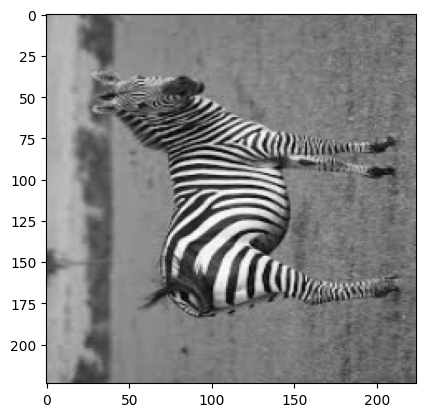

In [25]:
idx= 999
plt.imshow(X_train.iloc[idx].to_numpy().reshape(224,224),cmap = 'gray');
y_train.iloc[idx]

In [26]:
train_X = X_train.to_numpy().reshape(-1,224, 224)
train_X = np.divide(train_X, 255)
train_X = torch.tensor(train_X, dtype=torch.float32).unsqueeze(1)
train_Y = torch.tensor(np.array(y_train), dtype=torch.float32)
# ------------------------------
test_X = X_test.to_numpy().reshape(-1,224, 224)
test_X = np.divide(test_X, 255)
test_X = torch.tensor(test_X, dtype=torch.float32).unsqueeze(1)
test_Y = torch.tensor(np.array(y_test), dtype=torch.float32)

In [27]:
train_X.shape

torch.Size([1555, 1, 224, 224])

In [28]:
print(f"X_train shape: {train_X.shape}")
print(f"y_train shape: {train_Y.shape}")
print(f"X_test shape: {test_X.shape}")
print(f"y_test shape: {test_Y.shape}")

X_train shape: torch.Size([1555, 1, 224, 224])
y_train shape: torch.Size([1555, 15])
X_test shape: torch.Size([389, 1, 224, 224])
y_test shape: torch.Size([389, 15])


In [29]:
train_dataset = TensorDataset(train_X, train_Y)
test_dataset = TensorDataset(test_X, test_Y)

In [30]:
next(iter(train_dataset))[0].size()

torch.Size([1, 224, 224])

In [31]:
# class animals_classification(nn.Module):
#     def __init__(self):
#         super(animals_classification, self).__init__()
#         self.conv1 = nn.Conv2d(1,128, kernel_size = 3, padding = 1)
#         self.conv2 = nn.Conv2d(128,128, kernel_size = 3, padding = 1)
#         self.conv3 = nn.Conv2d(128,128, kernel_size = 3, padding = 1)
#         self.conv4 = nn.Conv2d(128,64, kernel_size = 3, padding = 1)
#         self.maxpooling = nn.MaxPool2d(kernel_size = 2)
#         self.Flatten1 = nn.Flatten()
#         self.fc1 = nn.Linear(64 * 14 * 14, 32)
#         self.fc2 = nn.Linear(32, 15)
#         self.batchnorm1 = nn.BatchNorm2d(128)
#         self.batchnorm2 = nn.BatchNorm2d(128)
#         self.batchnorm3 = nn.BatchNorm2d(128)
#         self.batchnorm4 = nn.BatchNorm2d(64)

#     def forward(self, x):
#         x = torch.relu(self.batchnorm1(self.conv1(x)))
#         x = self.maxpooling(x)
#         x = torch.relu(self.batchnorm2(self.conv2(x)))
#         x = self.maxpooling(x)
#         x = torch.relu(self.batchnorm3(self.conv3(x)))
#         x = self.maxpooling(x)
#         x = torch.relu(self.batchnorm4(self.conv4(x)))
#         x = self.maxpooling(x)
#         x = self.Flatten1(x)
#         x = torch.relu(self.fc1(x))

#         return F.log_softmax(self.fc2(x), dim=1)

In [32]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [33]:
# model = animals_classification().cuda() if device else model
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 15)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model = model.cuda() if device else model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
BATCH_SIZE = 32
NUMBER_OF_EPOCH = 25
IMG_SIZE = 224
criterion = nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s] 


In [34]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE)

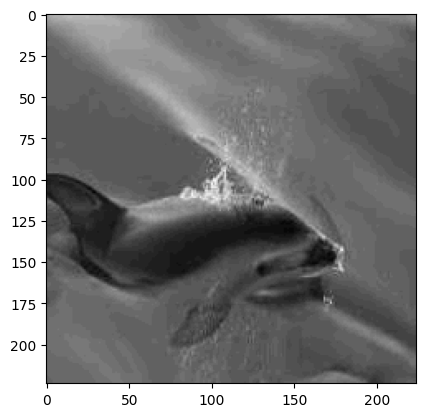

In [35]:
plt.imshow(next(iter(train_loader))[0][1].numpy().reshape(224,224),cmap = 'gray')

In [36]:
next(iter(train_loader))[0].size()

torch.Size([32, 1, 224, 224])

In [37]:
t = torch.cuda.FloatTensor(5,5)
t = t.to('cpu')
gc.collect()

/tmp/ipykernel_34/2817428052.py:1: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /usr/local/src/pytorch/torch/csrc/tensor/python_tensor.cpp:83.)
  t = torch.cuda.FloatTensor(5,5)


3527

In [38]:
loss2 = []
acc_per_batch= []

In [39]:
for images, labels in train_loader:
    optimizer.zero_grad()
    images, labels = images.to(device), labels.to(device)
    predict = model(images)
    loss = criterion(predict, labels)
    loss.backward()
    prediction = torch.argmax(predict, dim = 1)
    break


In [40]:
prediction

tensor([ 2,  6, 10,  4,  4,  6,  3, 11,  6,  4,  4,  3, 10,  4,  4,  3,  2,  2,
        11, 10, 11, 11,  2, 10, 11,  4, 11,  2,  6, 10, 10,  3],
       device='cuda:0')

In [41]:
torch.argmax(labels, dim = 1)

tensor([ 5,  6,  3,  6,  9,  7, 11,  3,  5, 13, 14,  3,  2,  8, 14,  1,  5, 12,
         9, 13,  8,  5,  4,  2,  1,  5,  3,  2,  5, 11, 13,  6],
       device='cuda:0')

In [ ]:
torch.cuda.empty_cache()
for i in tqdm(range(NUMBER_OF_EPOCH)):
    for images, labels in train_loader:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        predict = model(images)
        loss = criterion(predict, labels)
        loss.backward()
        prediction = torch.argmax(predict, dim=1)
        #accuracy = accuracy_score(labels, predict)
        #print(accuracy)
        #final_accuracy.append(accuracy)
        acc = (prediction == torch.argmax(labels, dim = 1)).sum().item() / len(labels)
        acc_per_batch.append(acc)
        optimizer.step()
        loss2.append(loss.item())
    print(f"Loss: {sum(loss2) / len(loss2)}")
    print(f"Accuracy: {sum(acc_per_batch) / len(acc_per_batch)}")


In [ ]:
# Evaluate the model
Eval_acc_per_batch = []
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    Eval_acc_per_batch= []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        prediction = torch.argmax(outputs,dim=1)
        acc = (prediction == torch.argmax(labels,dim=1)).sum().item() / len(labels)
        Eval_acc_per_batch.append(acc)
print(f"validation accuracy: {sum(Eval_acc_per_batch)/len(Eval_acc_per_batch):.4f}")